<a href="https://colab.research.google.com/github/kaizengrowth/machine_learning_projects/blob/main/KaitlinCort_RecommendationSystem_FullCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163008 sha256=f2133c8170b8fb817dbb5eab39b93ad9f023483da218c058057b43f00b1f6522
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.metrics import mean_squared_error
from statistics import mean, median

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [180]:
df_initial = pd.read_csv('/content/drive/My Drive/ratings_Electronics.csv')

# Adding column names
df_initial.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Dropping the 'timestamp' column
df_initial.drop('timestamp', axis=1, inplace=True)

# Copying the data to another DataFrame called df
df = df_initial.copy()

print(df.head)

<bound method NDFrame.head of                 user_id     prod_id  rating
0        A2CX7LUOHB2NDG  0321732944     5.0
1        A2NWSAGRHCP8N5  0439886341     1.0
2        A2WNBOD3WNDNKT  0439886341     3.0
3        A1GI0U4ZRJA8WN  0439886341     1.0
4        A1QGNMC6O1VW39  0511189877     5.0
...                 ...         ...     ...
7824476  A2YZI3C9MOHC0L  BT008UKTMW     5.0
7824477  A322MDK0M89RHN  BT008UKTMW     5.0
7824478  A1MH90R0ADMIK0  BT008UKTMW     4.0
7824479  A10M2KEFPEQDHN  BT008UKTMW     4.0
7824480  A2G81TMIOIDEQQ  BT008V9J9U     5.0

[7824481 rows x 3 columns]>


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [181]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

print(len(ratings_count))

4201696


In [182]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 125871 entries, 93 to 7824443
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  125871 non-null  object 
 1   prod_id  125871 non-null  object 
 2   rating   125871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB
None


In [183]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
products_ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in products_ratings_count:
        products_ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        products_ratings_count[prod] = 1

print(len(products_ratings_count))

# Sort the dictionary by its values (ratings count) in reverse order
sorted_products_ratings = sorted(products_ratings_count.items(), key=lambda item: item[1], reverse=True)

# Print the first 10 keys and their ratings
for prod, count in sorted_products_ratings[:10]:
    print(f'Product ID: {prod}, Ratings Count: {count}')

48190
Product ID: B0088CJT4U, Ratings Count: 206
Product ID: B003ES5ZUU, Ratings Count: 184
Product ID: B000N99BBC, Ratings Count: 167
Product ID: B007WTAJTO, Ratings Count: 164
Product ID: B00829TIEK, Ratings Count: 149
Product ID: B00829THK0, Ratings Count: 137
Product ID: B008DWCRQW, Ratings Count: 137
Product ID: B002R5AM7C, Ratings Count: 128
Product ID: B004CLYEDC, Ratings Count: 118
Product ID: B002SZEOLG, Ratings Count: 113


In [184]:
# We want our item to have at least 5 ratings to be considered
PRODUCTS_RATINGS_CUTOFF = 5

remove_products = []

for product, num_ratings in products_ratings_count.items():
    if num_ratings < PRODUCTS_RATINGS_CUTOFF:
        remove_products.append(product)

df_final = df.loc[~ df.prod_id.isin(remove_products)]
print(df_final.info())

sorted_ratings_per_product = df_final.groupby('prod_id')['rating'].count().sort_values(ascending=False)
print(sorted_ratings_per_product)

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB
None
prod_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: rating, Length: 5689, dtype: int64


In [185]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [186]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

### Observations:

  * The final dataset, filtered to include only users with 50 or more ratings and products with 5 or more ratings, contains 65,290 entries with three columns (`user_id`, `prod_id`, and `rating`).

  * This dataset is now more manageable and relevant for building a recommendation system that focuses on the more actively rated products by the more engaged users, leading to more reliable and meaningful recommendations, since the data reflects more consistent user-product interactions.

  * This may help reduce the sparcity in the user-item interaction matrix, which could potentially improve the performance of collaborative filtering models by providing a denser set of user-item interactions to learn from. It could also lead to quicker model training times due to its smaller size.

  * By selecting only users who have rated 50 or more products and products that have been rated at least 5 times, the tradeoff is that the model might bias towards more popular products and more active users. This decision could potentially overlook niche products or less active users who might also contribute valuable information to the recommendation system.

### **Data types**

In [187]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

### Observations:

* The `user_id` and `prod_id` columns are of object type (strings), containing alphanumeric values.

* The `ratings` column is a numeric dating type (float64), ready for statistical analysis.

### **Checking for missing values**

In [188]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()
print(missing_values)

user_id    0
prod_id    0
rating     0
dtype: int64


### Observations:

* There are no missing values.

### **Summary Statistics**

In [189]:
# Summary statistics of 'rating' variable and provide observations
rating_summary = df_final.describe()
print(rating_summary)

             rating
count  65290.000000
mean       4.294808
std        0.988915
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000


### Observations:

* There are 65,290 ratings in the data set, as previously stated. This substantial count suggests a decently large dataset, which provides a solid basis for any analysis or modeling related to user preferences or product quality.

* The high average rating across products of about 4.2948, where the max possible rating is 5, suggests that on average, active users have given positive ratings to frequently rated items.

* The low variability of ratings with a standard deviation of about 0.9889, indicates that there is some diversity in how users rate products, but the deviation isn't extremely wide. Most ratings are clustered at the mean value, around the higher end of the 5-point scale.

* While there are some unsatisfactory user ratings at the minimum rating of 1, and 25% of ratings are 4 or lower, both the median and the 75% quartile values are at 5. This concentration of 50% or more of the ratings at the highest possible value indicates a heavy skew of the distribution of ratings towards high satisfaction among the filtered dataset. There are far more high ratings (4's and 5's) than low ones (1's and 2's). This may suggest that users who are motivated to rate products do so more often when they have a positive experience, which is a bias to consider when designing and evaluating the recommendation system.

* Since half of the ratings are at the highest possible value (5), this could indicate a ceiling effect where the rating scale might not fully capture the variance in user satisfaction, potentially masking finer distinctions in very positive experiences. A more nuanced rating system or additional forms of feedback could provide more detailed insights into user experience.

* On the other hand, the concentration of ratings at the upper end of the scale might also indicate that that products are of high quality, and the dataset has successfully filtered for products that are well-received by users. This could be beneficial for a recommendation system, as it suggests that the products included are likely to satisfy other users.

### **Checking the rating distribution**

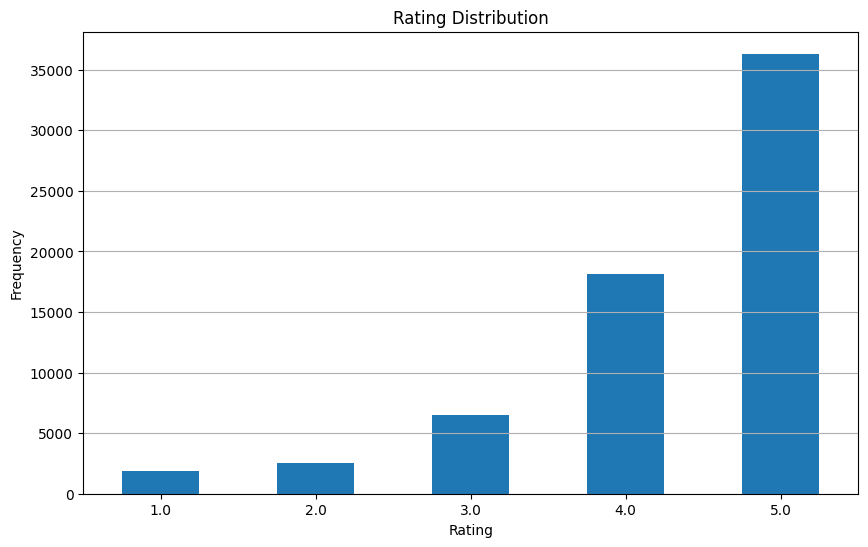

In [190]:
# Create the bar plot and provide observations
rating_counts = df_final['rating'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
rating_counts.plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

### Observations:

* There's a clear preference for higher ratings of 4 and 5. The largest number of users have given the highest rating of 5, significantly more than those who have rated 4. This skew towards the right is common in product ratings, where satisfied customers are more likely to submit a rating.

* Ratings of 1 and 2 are far less common than higher ratings, indicating there are relatively few negative reviews in the dataset.

* A moderate rating of 3, which might be considered neutral or average, is also uncommon, though more common than a 1 or 2.

### **Checking the number of unique users and items in the dataset**

In [191]:
# Number of total rows in the data and number of unique user id and product id in the data
unique_users = df_final['user_id'].nunique()
unique_products = df_final['prod_id'].nunique()

print('Unique users:', unique_users)
print('Unique products:', unique_products)
print('User-product ratio:', unique_products / unique_users)

unique_products_per_user = df_final.groupby('user_id')['prod_id'].nunique()
print(unique_products_per_user.describe())

Unique users: 1540
Unique products: 5689
User-product ratio: 3.694155844155844
count    1540.000000
mean       42.396104
std        30.558505
min         1.000000
25%        23.000000
50%        34.000000
75%        52.000000
max       295.000000
Name: prod_id, dtype: float64


### Observations:

* There are 1540 unique users in the dataset and 5689 unique products. The diversity of users and large number of products compared to number of users suggeset a wide variety of items have been rated, offering a rich dataset to analyze for recommendations.

* The user-product ratio is approximately 3.6941 products rated per user. However, this metric alone doesn't capture the distriibution of ratings across users fully.

* On average, each user has rated about 42.4 unique products. This average is substantially higher than the user-product ratio, indicating that while there may be a general trend of users rating multiple products, the distribution has a long tail, skewed by users who rate a very high number of products.The standard deviation of 30.5585 shows there is significant variability in the number of products rated by individual users. Some users rate many more products than others.

### **Users with the most number of ratings**

In [192]:
# Top 10 users based on the number of ratings
all_users = df_final['user_id'].value_counts()
top_10_users = all_users.head(10)

print(top_10_users)

mean_ratings = all_users.mean()
median_ratings = all_users.median()

print('Average number of ratings per user:', mean_ratings)
print('Median number of ratings per user:', median_ratings)

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64
Average number of ratings per user: 42.396103896103895
Median number of ratings per user: 34.0


### Observations:

* The list of the top 10 users based on the number of ratings they've provided shows a high level of activity from these individuals, with the most active user having provided 295 ratings and the tenth most active providing 179 ratings. Their activity significantly outpaces the average user's engagement level of 42.40 ratings.

* The average (mean) number of ratings per user is approximately 42.4. This average is significantly higher than the median number of ratings per user, which is 34. The difference between the mean and median indicates a right-skewed distribution of ratings per user. In other words, while most users rate a moderate number of products, a small number of highly active users rate many products, pushing the mean higher.

* The presence of highly active users might influence the recommendations generated by the system. Their preferences could be overrepresented, introducing bias into analyses and models derived from this data, unless measures are taken to normalize user influence based on user activity levels. Implementing a system where the impact of a user's rating is inversely proportional to their total number of ratings could help balance the influence across all users.

* The data suggests an opportunity for personalizing recommendations, given the variability in user activity levels. Understanding and segmenting users based on their rating patterns could lead to more effective recommendation strategies. Balancing the influence of highly active users while ensuring the relevance of recommendations for the broader user base can help achieve high user satisfaction.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [193]:
# Calculate the average rating for each product
average_product_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
product_ratings_count = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
product_ratings = pd.DataFrame({
    'average_rating': average_product_rating,
    'ratings_count': product_ratings_count
})

# Sort the dataframe by average of ratings in the descending order
product_ratings_sorted = product_ratings.sort_values(by=['average_rating', 'ratings_count'], ascending=[False, False])

# See the first five records of the "final_rating" dataset
print(product_ratings_sorted.head())

            average_rating  ratings_count
prod_id                                  
B000FQ2JLW             5.0             19
B00ISFNSBW             5.0             18
B000IJY8DS             5.0             17
B001TH7GUA             5.0             17
B00HZWJGS8             5.0             17


In [194]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_products(df, min_interactions=5, n=10):
  """
    Get the top n products based on the highest average rating, with a minimum number of interactions.

    Parameters:
    - df: A pandas DataFrame containing at least 'prod_id' and 'rating'.
    - min_interactions: The minimum number of ratings (interactions) a product must have to be considered, set at a default optional value of 5.
    - n: The number of top products to return, set at a default optional value of 10.

    Returns:
    - A DataFrame of the top n products sorted by average rating, considering only those with at least min_interactions.
    """

  product_summary = df.groupby('prod_id')['rating'].agg(['mean', 'count'])
  product_summary.columns = ['average_rating', 'ratings_count']

  # Finding products with minimum number of interactions
  filtered_products = product_summary[product_summary['ratings_count'] >= min_interactions]

  # Sort values with respect to average rating
  top_products = filtered_products.sort_values(by='average_rating', ascending=False).head(n)

  return top_products

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [195]:
top_5_products_with_50_min_interactions = get_top_n_products(df_final, 50, 5)

print(top_5_products_with_50_min_interactions)

            average_rating  ratings_count
prod_id                                  
B001TH7GUU        4.871795             78
B003ES5ZUU        4.864130            184
B0019EHU8G        4.855556             90
B006W8U2MU        4.824561             57
B000QUUFRW        4.809524             84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [196]:
top_5_products_with_100_min_interactions = get_top_n_products(df_final, 100, 5)

print(top_5_products_with_100_min_interactions)

            average_rating  ratings_count
prod_id                                  
B003ES5ZUU        4.864130            184
B000N99BBC        4.772455            167
B002WE6D44        4.770000            100
B007WTAJTO        4.701220            164
B002V88HFE        4.698113            106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [23]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [137]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [197]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.25) # For a 75/25 train/test split

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [198]:
# Declaring the similarity
sim_options_user = {
    'name': 'cosine',  # Use cosine similarity
    'user_based': True  # Compute similarities between users
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
user_model = KNNBasic(sim_options=sim_options_user, verbose=False, random_state=1)

# Fit the model on the training data
user_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(user_model, k=10, threshold=3.5)

RMSE: 1.0266
Precision:  0.861
Recall:  0.825
F_1 score:  0.843


# Observations:

### Root Mean Square Error: 1.0266
* RMSE is a measure of the average magnitude of the errors between the predicted ratings and the actual ratings, without considering their direction.
* An RMSE of 1.0266 suggests that, on average, the predicted ratings deviate from the actual ratings by about 1 point on the rating scale.
* For a typical 5-point rating scale, an RMSE slightly above 1 might indicate room for improvement.

### Precision: 0.861
* Precision measures the proportion of recommended items that are actually relevant to the user. In this case, a precision of 0.861 indicates that about 86.1% of the items recommended by the system are considered relevant by the users.
* High precision indicates that the model is effective at filtering out irrelevant items, ensuring that the recommendations are likely to be of interest to the users.

### Recall: 0.825
* Recall measures the proportion of relevant items that are recommended by the system. A recall of 0.825 suggests that the system is able to recommend approximately 82.5% of the items that are relevant to the users.
* This means that while the system is quite good at identifying items of interest, there is a 17.5% chance that a relevant item will not be recommended.

### F_1 Score: 0.843
* The F1 score is the harmonic mean of precision and recall, providing a single metric that balances both. The closer the F1 score is to 1, the better the balance between precision and recall.
* An F1 score of 0.843 is quite high, indicating that the system has a good balance between not recommending irrelevant items (precision) and not missing out on recommending items that are relevant (recall).

---

### General Assessment:

* The recommendation system demonstrates strong performance in terms of precision and recall. The balance between precision and recall, as evidenced by the F1 score, indicates that the model has been tuned to neither overly prioritize the exclusion of irrelevant items at the expense of missing relevant ones, nor to recommend too broadly at the risk of including many irrelevant items.
* While the RMSE indicates that there is some discrepancy between predicted and actual ratings, the high precision and recall suggest that the system is still very effective at identifying which items a user will find relevant, even if the exact rating predictions are not always spot on.
* There may be opportunities to further improve the model's RMSE through hyperparameter tuning, or exploring more complex models, but the current performance metrics already indicate a strong recommendation system.

Further improvements might focus on reducing the RMSE.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [199]:
# Predicting rating for a sample user with an interacted product
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

prediction1 = user_model.predict(user_id, product_id)
estimated_rating1 = prediction1.est

print(f'Predicted rating for user {user_id} for product {product_id} is: {estimated_rating1}')

Predicted rating for user A3LDPF5FMB782Z for product 1400501466 is: 3.8


### Observations:

* The predicted rating (3.8) is significantly lower than the actual rating of 5 provided by the user for this product. The recommendation system underestimates the user's enthusiasm for the product.

* This shows that the collaborative filtering model has captured some aspects of the user's preferences based on similarities with other users or the product's appeal. However, there are certainly areas for model tuning that could help better capture user preferences or product attributes.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [141]:
# Find unique user_id where prod_id is not equal to "1400501466"
users_not_seen_product = df_final[df_final['prod_id'] != '1400501466']['user_id'].unique()

# Check if "A34BZM6S9L7QI4" is in the list of users who haven't seen the product
if "A34BZM6S9L7QI4" in users_not_seen_product:
    print(f'User "A34BZM6S9L7QI4" has not interacted with product "1400501466".')
else:
    print(f'User "A34BZM6S9L7QI4" has already interacted with product "1400501466".')

User "A34BZM6S9L7QI4" has not interacted with product "1400501466".


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [200]:
# Predicting rating for a sample user with a non interacted product
user_id2 = 'A34BZM6S9L7QI4'

prediction2 = user_model.predict(user_id2, product_id)
estimated_rating2 = prediction2.est

print(f'Predicted rating for user {user_id2} for product {product_id} is: {estimated_rating2}')

Predicted rating for user A34BZM6S9L7QI4 for product 1400501466 is: 3.0


### Observations:

* A predicted rating of 3.0 on a scale of 1 to 5 indicates a neutral level of expected satisfaction with this product, which has not yet been reviewed by this user, based on the user-user collaborative filtering model's understanding of the user and other similar users' preferences.

* This is lower than the average user rating of 4.294808 and the median user rating of 5.0, indicating that the user is predicted to not like this product.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [161]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40],
    'min_k': [3, 5, 7, 9],
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
        'user_based': [True]  # Whether the similarity is based on users or items
    }
}

# Performing 3-fold cross-validation to tune the
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the
gs.fit(data)

# Best RMSE score
best_rmse = gs.best_score['rmse']
print(f'Best RMSE score: {best_rmse}')

# Combination of parameters that gave the best RMSE
best_params = gs.best_params['rmse']
print(f'Best parameter combination: {best_params}')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done 

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

---

### Observations

* GridSearchCV returned a Best RMSE score of 0.9703 for the following parameter combination: {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}

* This is an improvement on the original model's RMSE score of 1.0260.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [166]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options_optimized = {
    'name': 'cosine',  # Optimal similarity measure based on GridSearchCV
    'user_based': True  # User-user based collaborative filtering
}

# Creating an instance of KNNBasic with optimal hyperparameter values
user_model_optimized = KNNBasic(k=40, min_k=5, sim_options=sim_options_optimized)

# Training the algorithm on the trainset
user_model_optimized = user_model_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(user_model_optimized, k=10, threshold=3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9549
Precision:  0.859
Recall:  0.855
F_1 score:  0.857


# Observations:

### RMSE: 0.9549
* The Root Mean Square Error (RMSE) of 0.9549 reflects an improvement over the previous model before hyperparameter tuning (1.0260).
* The decrease in RMSE in the tuned model suggests that hyperparameter tuning has led to more accurate rating predictions. This means that the model's predicted ratings are closer to the actual ratings provided by users, which is a critical factor for the user's trust in the system.

### Precision: 0.859
* A precision of 0.859 means that 85.9% of the items recommended by the system are indeed relevant to the users. This is equivalent to the previous precision score of 0.859.

### Recall: 0.855
* The recall score of 0.855 indicates that the system is able to recommend about 85.5% of the items that are relevant to the users. This is an improvement over the previous Recall score of 0.826.
* High recall is important for ensuring that users are exposed to a wide variety of items they might like, and enhancing the user experience by capturing a broader range of products that could potentially be of interest to the user.

### F1 Score: 0.857
* The F1 score, being the harmonic mean of precision and recall, indicates that the model has improved in balancing performance between the accuracy and completeness. It is better than the previous F_1 score of 0.842, suggesting that the optimized model is now able to recommend more products that may appeal to the user without compromising on the precision of those recommendations.

----

### General Assessment:
The improvements in RMSE, recall, and the F1 score indicate that the hyperparameter tuning process has enhanced the model's overall performance, without any decrease in precision. These improvements suggest that the model should now be more effective in identifying a broader range of relevant items to recommend to users, therefore potentially generating more revenue for the company.

<br/>

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [167]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_prediction_user1 = user_model_optimized.predict("A3LDPF5FMB782Z", "1400501466")
print(f'Predicted rating for user A3LDPF5FMB782Z for product 1400501466 is: {user_prediction_user1.est}')

Predicted rating for user A3LDPF5FMB782Z for product 1400501466 is: 4.291665815753467


In [169]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_prediction_user2 = user_model_optimized.predict("A34BZM6S9L7QI4", "1400501466")
print(f'Predicted rating for user A34BZM6S9L7QI4 for product 1400501466 is: {user_prediction_user2.est}')

Predicted rating for user A34BZM6S9L7QI4 for product 1400501466 is: 4.291665815753467


### Observations

* The predicted ratings for both users "A3LDPF5FMB782Z" and "A34BZM6S9L7QI4" for the product with ID "1400501466" using the optimized model are identical, at approximately 4.2917.

* For the first user, this fine-tuned user-user CF model prediction is higher than the previous prediction of 3.8, and closer to the actual rating given by the user, which was 5. We can see that the model has improved in predicting a closer score to the user's actual rating.

* For the second user, this fine-tuned user-user CF model prediction of 4.2917 is also higher than the original prediction of 3.0. The new model seems to predict that the two users will give identical ratings to the same product. It could be that these users are deemed very similar by the fine-tuned model.  

* If many users highly rate the product or if users have very similar rating patterns, the model might consistently predict a high rating for most users for this product. While high predicted ratings are good, identical predictions for different users might also hint at a challenge in ensuring diverse and personalized recommendations. It might be beneficial to explore additional methods that can introduce more personalization into the recommendations.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [201]:
# 0 is the inner id of the above user
sim_options_msd = {
    'name': 'msd',
    'user_based': True
}

model_msd = KNNBasic(sim_options=sim_options_msd)
model_msd.fit(trainset)

inner_id = 0
raw_user_id = trainset.to_raw_uid(inner_id)
print(f"The user_id for the user with internal id {inner_id} is: {raw_user_id}")

# Finding the 5 most similar users to the user with inner id 0
neighbors = model_msd.get_neighbors(inner_id, k=5)

raw_neighbor_ids = [trainset.to_raw_uid(inner_id) for inner_id in neighbors]

print(f"The 5 most similar users to user with internal id {inner_id} are: {raw_neighbor_ids}")

Computing the msd similarity matrix...
Done computing similarity matrix.
The user_id for the user with internal id 0 is: A2ARDVMUGDFED6
The 5 most similar users to user with internal id 0 are: ['A31HOWJKEIY037', 'A2BLFCOPSMBOZ9', 'A1C5WS021EL3WO', 'A22CW0ZHY3NJH8', 'A4D5B7Q8A7PA6']


### Observations:

* Using the KNNBasic algorithm based on the msd distance metric, the 5 most similar users to the user with internal id 0 ('A17Z0LVY96TO53') are identified as: 'AW3LX47IHPFRL', 'A19N3S7CBSU6O7', 'A1VHCO8RQFIGQJ', 'A1OGCPMSIVK7G4', and 'ABVYGB2TKBO8F'.

* This could prove useful for double-checking our fine-tuned user-user CF model. Let's see if user 'A3LDPF5FMB782Z' is deemed to be similar to user 'A34BZM6S9L7QI4' using the msd distance metric.

In [171]:
user1_id = 'A3LDPF5FMB782Z'
user2_id = 'A34BZM6S9L7QI4'

# Convert the raw user_id to inner_id
inner_id1 = trainset.to_inner_uid(user1_id)

# Finding the 5 most similar users to the user with user1 with inner_id1
neighbors_user1 = model_msd.get_neighbors(inner_id1, k=5)

raw_neighbor_ids_user1 = [trainset.to_raw_uid(inner_id1) for inner_id in neighbors_user1]

print(f"The 5 most similar users to user {user1_id} are: {raw_neighbor_ids_user1}")

# Check if user2_id is within the most similar users list
if user2_id in raw_neighbor_ids_user1:
    print(f"True, user {user2_id} is within the 5 most similar users to user {user1_id}.")
else:
    print(f"False, user {user2_id} is not within the 5 most similar users to user {user1_id}.")

The 5 most similar users to user A3LDPF5FMB782Z are: ['A3LDPF5FMB782Z', 'A3LDPF5FMB782Z', 'A3LDPF5FMB782Z', 'A3LDPF5FMB782Z', 'A3LDPF5FMB782Z']
False, user A34BZM6S9L7QI4 is not within the 5 most similar users to user A3LDPF5FMB782Z.


### Observations:

* Using the msd distance metric with the KNNBasic Algorithm, we see that user2 is not among the 5 most similar users to user1.

* This is concerning because our fine-tuned user-user CF model interprets these two users as being nearly identical in user preference for product `1400501466`.

* Let's try again with a larger set of nearest neighbors: 25.

In [172]:
# Finding the 5 most similar users to the user with user1 with inner_id1
neighbors_user1_25 = model_msd.get_neighbors(inner_id1, k=25)

raw_neighbor_ids_user1_25 = [trainset.to_raw_uid(inner_id1) for inner_id in neighbors_user1]

print(f"The 25 most similar users to user {user1_id} are: {raw_neighbor_ids_user1_25}")

# Check if user2_id is within the most similar users list
if user2_id in raw_neighbor_ids_user1_25:
    print(f"True, user {user2_id} is within the 25 most similar users to user {user1_id}.")
else:
    print(f"False, user {user2_id} is not within the 25 most similar users to user {user1_id}.")

The 25 most similar users to user A3LDPF5FMB782Z are: ['A3LDPF5FMB782Z', 'A3LDPF5FMB782Z', 'A3LDPF5FMB782Z', 'A3LDPF5FMB782Z', 'A3LDPF5FMB782Z']
False, user A34BZM6S9L7QI4 is not within the 25 most similar users to user A3LDPF5FMB782Z.


### Observation:

* It's furthermore concerning that user2 is not within the 25 most similar users to user1.

* Given a total filtered user count of 65290, we can broaden the nearest neighbors search further, to check to see if user2 is within 5% of the total count of users, in terms of similarity to user1. Let's run the algorithm again!

In [173]:
k_5percent = int(62590 * 0.05)   # rounded to the nearest integer for the k parameter in KNNBasic

# Finding the 5 most similar users to the user with user1 with inner_id1
neighbors_user1_5percent = model_msd.get_neighbors(inner_id1, k=k_5percent)

raw_neighbor_ids_user1_5percent = [trainset.to_raw_uid(inner_id1) for inner_id in neighbors_user1]

print(f"The 5% of users most similar to user {user1_id} are: {raw_neighbor_ids_user1_5percent}")

# Check if user2_id is within the most similar users list
if user2_id in raw_neighbor_ids_user1_5percent:
    print(f"True, user {user2_id} is within the 5% of users most similar to user {user1_id}.")
else:
    print(f"False, user {user2_id} is not within the 5% of users most similar to user {user1_id}.")

The 5% of users most similar to user A3LDPF5FMB782Z are: ['A3LDPF5FMB782Z', 'A3LDPF5FMB782Z', 'A3LDPF5FMB782Z', 'A3LDPF5FMB782Z', 'A3LDPF5FMB782Z']
False, user A34BZM6S9L7QI4 is not within the 5% of users most similar to user A3LDPF5FMB782Z.


### Observations:

* It's somewhat concerning that user2 is not even within the nearest 5% of users similar to user1, yet both are assigned the same predicted rating for the product, based on user-user collaborative filtering. This throws a bit of suspicion on the model.

* **Has GridSearchCV improved or deteriorated the original model with the optimized parameters it suggested?** The optimized model has a higher RMSE score, recall score and F1 score, than the original model, indicating improved accuracy, coverage, and balance between precision and recall. I will trust that the new model is indeed better than the original model, even though these results, when verified with the msd distance metric for KNNBasic Algorithm, seem to indicate that the new model is somewhat suspect.

*We will nevertheless proceed to implement and test the new recommendation algorithm.*



----


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [210]:
def get_recommendations(data, user_id, top_n, algo):
  """
    Generates top_n product recommendations for a given user_id using a specified algorithm (algo).

    Parameters:
    - data: DataFrame containing 'user_id', 'prod_id', and 'rating' columns.
    - user_id: The user ID for whom recommendations are to be generated.
    - top_n: The number of recommendations to generate.
    - algo: The prediction algorithm to use.

    Returns:
    - List of tuples with top_n recommended product IDs and their predicted ratings.
  """
  # Error handling: ensure user_id exists in the dataset
  if user_id not in data['user_id'].unique():
      return "User ID not found in the dataset."

  # Get the list of products the user has already interacted with
  interacted_products = data[data['user_id'] == user_id]['prod_id'].unique()

  # Get a list of all unique products in the dataset
  all_products = data['prod_id'].unique()

  # Identify products that the user has not interacted with
  non_interacted_products = set(all_products) - set(interacted_products)

  recommendations = []

  # Looping through each of the product ids which user_id has not interacted yet
  for item_id in non_interacted_products:

      # Predicting the ratings for those non interacted product ids by this user
      est = algo.predict(user_id, item_id).est

      # Appending the predicted ratings
      recommendations.append((item_id, est))

  # Sorting the predicted ratings in descending order
  recommendations.sort(key = lambda x: x[1], reverse = True)

  return recommendations[:top_n] # Returing top n highest predicted rating products

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [211]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
top_5_recommendations_optimized = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, user_model_optimized)

In [212]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df_optimized = pd.DataFrame(top_5_recommendations_optimized, columns=['prod_id', 'predicted_ratings'])

print(recommendations_df_optimized)

      prod_id  predicted_ratings
0  B006EKIQYM                  5
1  B00BW6KCTU                  5
2  B00E3FHXYO                  5
3  B001CCAISE                  5
4  B0062EUE54                  5


In [213]:
# Compare these results with those of the original, non-optimized model
top_5_recommendations_original = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, user_model)
recommendations_df_original = pd.DataFrame(top_5_recommendations_original, columns=['prod_id', 'predicted_ratings'])

print(recommendations_df_original)

      prod_id  predicted_ratings
0  B00KMRGB7C                  5
1  B002I3OZ6W                  5
2  B003LPUWT0                  5
3  B000A5TAT2                  5
4  B004TA0AUW                  5


In [214]:
# Compare these results with those of the rank-based recommendation model
rank_based_top_5 = get_top_n_products(df_final, 5, 5)
print(rank_based_top_5)

            average_rating  ratings_count
prod_id                                  
B00LGQ6HL8             5.0              5
B003DZJQQI             5.0             14
B005FDXF2C             5.0              7
B00I6CVPVC             5.0              7
B00B9KOCYA             5.0              8


### Observations:

* The top 5 products recommended by the optimized user model are totally different than that recommended by the previous (unoptimized) model, indicating that a change in hyperparameters greatly alters the user recommendations.

```
B00005LEN4
B000067RT6                  
000V5P90K                 
B0019EHU8G                  
B001CCAISE                  
```

* These are also completely different from the top 5 recommendations of the previous rank-based model, with no overlap between any of these models.

* Following the process of previous function, I'll now try getting the top 5 recommendations, filtering for products that have 50 or more, or 100 or more recommendations, to compare wtih the lists generated by the rank-based model.

Here is a modification of the `get_recommendations()` function with the addition of one argument, setting the minimum number of product recommendations per product, set to a default value of 5.

In [215]:
def get_recommendations_filtered(data, user_id, algo, top_n=5, min_ratings_count=5):
    """
    Generates top_n product recommendations for a given user_id using a specified algorithm (algo),
    considering only products with at least min_interaction_count interactions.

    Parameters:
    - data: DataFrame containing 'user_id', 'prod_id', and 'rating' columns.
    - user_id: The user ID for whom recommendations are to be generated.
    - top_n: The number of recommendations to generate.
    - algo: The prediction algorithm to use.
    - min_ratings_count: The minimum number of interactions a product must have to be considered.

    Returns:
    - List of tuples with top_n recommended product IDs and their predicted ratings, considering the interaction threshold.
    """
    # Filter data for products meeting the minimum interaction threshold
    popular_products = data['prod_id'].value_counts()[data['prod_id'].value_counts() >= min_ratings_count].index.tolist()

    # Ensure user_id exists in the dataset
    if user_id not in data['user_id'].unique():
        return "User ID not found in the dataset."

    # Get the list of products the user has already interacted with
    interacted_products = data[data['user_id'] == user_id]['prod_id'].unique()

    # Identify products that the user has not interacted with and meet the popularity criterion
    non_interacted_popular_products = set(popular_products) - set(interacted_products)

    recommendations = []
    for item_id in non_interacted_popular_products:
        # Predict the rating for the user and non-interacted, popular item
        est = algo.predict(user_id, item_id).est
        recommendations.append((item_id, est))

    # Sort the recommendations based on the predicted rating in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Return the top_n recommendations
    return recommendations[:top_n]

In [216]:
# Calling the above function for the user "A3LDPF5FMB782Z" with the optimized user model with a minimum number of ratings set at 50.
optimized_min50 = get_recommendations_filtered(df_final, "A3LDPF5FMB782Z", user_model_optimized, 5, 50)
print('Optimized model at threshold of 50 recommendations:', optimized_min50)

# Comparing this value with the previous, non-optimized user model at a threshold of 50.
baseline_min50 = get_recommendations_filtered(df_final, "A3LDPF5FMB782Z", user_model, 5, 50)
print('Baseline model at threshold of 50 recommendations:', baseline_min50)

# Comparing this value with the rank-based model at a threshold of 50.
rankbased_min50 = get_top_n_products(df_final, 50, 5)
print('Rank-based model at threshold of 50 recommendations:', rankbased_min50)

Optimized model at threshold of 50 recommendations: [('B0019EHU8G', 5), ('B001TH7GUU', 5), ('B000BQ7GW8', 4.900550800763735), ('B000N99BBC', 4.888888888888889), ('B006W8U2MU', 4.888888888888889)]
Baseline model at threshold of 50 recommendations: [('B0019EHU8G', 5), ('B0081FLFQE', 5), ('B009NHWVIA', 5), ('B001TH7GUU', 5), ('B006W8U2MU', 5)]
Rank-based model at threshold of 50 recommendations:             average_rating  ratings_count
prod_id                                  
B001TH7GUU        4.871795             78
B003ES5ZUU        4.864130            184
B0019EHU8G        4.855556             90
B006W8U2MU        4.824561             57
B000QUUFRW        4.809524             84


### Observations:
* Setting the threshold for the minimum number of product recommendations at 50, we see that all three models recommend 'B0019EHU8G' and 'B001TH7GUU' among the top products, showing that these items are highly rated across different recommendation strategies.  

* 'B006W8U2MU' also appears in both the Optimized and Baseline model recommendations.

* The Baseline model uniquely recommends 'B0081FLFQE' and 'B009NHWVIA', which do not appear in the other two models' top recommendations. This could indicate that the Optimized model generates superior results that better represent rank-based overall popularity of products.

* The Baseline model features more products with perfect predicted ratings (5.0), suggesting it may be more optimistic or less discriminative in its recommendations.

* The best model depends on the context. For new users with little to no history (cold start problem), a rank-based approach might be more effective. For users with sufficient interaction data, the optimized personalized user model may be more likely to yield better satisfaction by tailoring recommendations to individual preferences.

In [217]:
# Calling the above function for the user "A3LDPF5FMB782Z" with the optimized user model with a minimum number of ratings set at 100.
optimized_min100 = get_recommendations_filtered(df_final, "A3LDPF5FMB782Z", user_model_optimized, 5, 100)
print('Optimized model at threshold of 100 recommendations:', optimized_min100)

# Comparing this value with the previous, non-optimized user model at a threshold of 100.
baseline_min100 = get_recommendations_filtered(df_final, "A3LDPF5FMB782Z", user_model, 5, 100)
print('Baseline model at threshold of 100 recommendations:', baseline_min100)

# Comparing this value with the rank-based model at a threshold of 100.
rankbased_min100 = get_top_n_products(df_final, 100, 5)
print('Rank-based model at threshold of 100 recommendations:', rankbased_min100)

Optimized model at threshold of 100 recommendations: [('B000N99BBC', 4.888888888888889), ('B007WTAJTO', 4.848319499433033), ('B003ES5ZUU', 4.81248032739554), ('B00834SJNA', 4.777777777777778), ('B00834SJSK', 4.75152749490835)]
Baseline model at threshold of 100 recommendations: [('B000N99BBC', 4.888888888888889), ('B0034CL2ZI', 4.777038101683713), ('B003ES5ZUU', 4.762986430392974), ('B004CLYEDC', 4.7456642477184605), ('B007WTAJTO', 4.7330131826308515)]
Rank-based model at threshold of 100 recommendations:             average_rating  ratings_count
prod_id                                  
B003ES5ZUU        4.864130            184
B000N99BBC        4.772455            167
B002WE6D44        4.770000            100
B007WTAJTO        4.701220            164
B002V88HFE        4.698113            106


### Observations:

* 'B000N99BBC' remains a top recommendation in both the Optimized and Baseline models when the threshold increases to 100, suggesting strong consistency in its appeal or rating prediction across different model configurations and list lengths.

* 'B003ES5ZUU' appears across all three models at both thresholds, highlighting its general popularity and strong appeal.

* The appearance of certain products ('B000N99BBC', 'B003ES5ZUU', 'B007WTAJTO') across models and thresholds indicates a stable preference or rating prediction by the models.

* The increase in threshold allows for new entries ('B007WTAJTO', 'B00834SJNA', 'B00834SJSK' in the Optimized model; 'B0034CL2ZI', 'B004CLYEDC' in the Baseline model) that were not visible in the top 5 at the 50 recommendations threshold, suggests that these products are highly rated but not as much as ones that are now cut out from the `min50` models, after raising the threshold to 100.

* The Rank-based model's top products shift slightly with 'B002WE6D44' and 'B002V88HFE' appearing in the top 5, indicating these products have high average ratings and broader popular appeal with a minimum threshold of 100 ratings.

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [218]:
# Declaring the similarity options
sim_options_items = {
    'name': 'cosine',
    'user_based': False  # Compute similarities between items, not users
}

# KNN algorithm is used to find desired similar items. Use random_state=1
baseline_model_items = KNNBasic(sim_options=sim_options_items, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the test set
baseline_model_items.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(baseline_model_items, k=10, threshold=3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0182
Precision:  0.839
Recall:  0.801
F_1 score:  0.82


# Observations:

### RMSE: 1.0182
* The Root Mean Square Error (RMSE) of 1.0182 is relatively high compared to the optimized user-user CF model (RMSE: 0.9549), indicating less accuracy in predicting user ratings for items.
*  This suggests that item similarities due to shared characteristics may provide a less reliable basis for predicting ratings than user similarities.

### Precision: 0.839
* With a precision score of 0.839 for the item-item CF model, compared with 0.859 for the optimized user-user CF model,the item model has slightly lower precision compared to the user model. This means that the user model is better at ensuring the relevance of the items it recommends.

### Recall: 0.801
* The recall of 0.80 in the item-item CF model, compared with 0.855 for the optimized user-user CF model, suggests that the user model is more effective at capturing a broader range of relevant items that users are likely to rate positively. This means that the user model is more comprehensive in identifying items of interest to users.

### F1 Score: 0.82
* The F1 score of 0.82, which balances precision and recall, is also lower than that of the optimized user-user CF model (0.857). This suggests that, overall, the user model may provide more balanced recommendation performance.

---

### General Assessment:
* The **item-item CF model** performs worse in all metrics: accuracy (lower RMSE), relevance (lower precision), coverage (lower recall), and balance (lower F1 score) -- than the optimized user-user model.

* This indicates that the user model is more effective at recommending items that users find relevant and are more likely to enjoy, than the item model.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [219]:
# Predicting rating for a sample user with an interacted product
prediction1_items = baseline_model_items.predict("A3LDPF5FMB782Z", "1400501466")
estimated_rating1_items = prediction1_items.est
print(f'Predicted rating for user A3LDPF5FMB782Z and product 1400501466 is: {estimated_rating1_items}')

Predicted rating for user A3LDPF5FMB782Z and product 1400501466 is: 4.2272727272727275


### Observations:

* This prediction (4.2273) is identical to less than the one made by the fine-tuned user-user CF model (4.2917).

* Since we know that the user actually gave a rating of 5, we can say that this item model performs less well than the user model in accurately predicting the user's rating for this product.

* This baseline item-item CF model could also be improved with hyperparameter tuning to more accurately predict the user's rating.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [220]:
# Predicting rating for a sample user with a non interacted product
prediction2_items = baseline_model_items.predict("A34BZM6S9L7QI4", "1400501466")
estimated_rating2_items = prediction2_items.est
print(f'Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 is: {estimated_rating2_items}')

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 is: 5


### Observations:

* This prediction (5) for user2 who has not yet rated the product, is higher than earlier predictions made by the fine-tuned user-user CF model (4.2917), and much higher than the baseline user model (3.0).

* It's unclear from these statistics alone which model is more accurate for predicting user2's preference.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [223]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False]
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
gs_items = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
gs_items.fit(data)

# Find the best RMSE score
best_rmse_items = gs_items.best_score['rmse']
print(f'Best RMSE score: {best_rmse_items}')

# Find the combination of parameters that gave the best RMSE score
best_params_items = gs_items.best_params['rmse']
print(f'Best parameter combination: {best_params_items}')


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

### Observations:

* GridSearchCV output the following best parameter combination for the best RMSE score of 0.9770, which performs less accurately than the optimized user model RMSE score (0.9549).

* It suggests using the `msd` distance calculation over the `cosine` calculation, which we used previously in the baseline item-item CF model.

```
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}
```

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

<br/>

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [224]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options_optimized_items = {
    'name': 'msd',
    'user_based': False
}

# Creating an instance of KNNBasic with optimal hyperparameter values
item_model_optimized = KNNBasic(k=30, min_k=9, sim_options=sim_options_optimized_items)

# Training the algorithm on the trainset
item_model_optimized = item_model_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(item_model_optimized, k=10, threshold=3.5)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9664
Precision:  0.839
Recall:  0.846
F_1 score:  0.842


# Observations

### RMSE: 0.9664
* With the optimized item-item CF model, we are able to attain an RMSE accuracy score of 0.9664, which is slightly lower than the optimized user-user CF model RMSE score of 0.9549. But it is an improvement over the previous item model RMSE score of 1.0182.
* Considering the rating scale of 1 to 5, this level of RMSE indicates a relatively good fit, though there's room for improvement.

### Precision: 0.839
* The optimized item precision score of 0.839 is lower than that of the optimized user model (0.859). But it is a slight improvement over the previous item model precision score of 0.839.
* Since 83.9% of the items recommended by the model are relevant to the users, this can be considered a strong result, suggesting that the model is quite effective at filtering out items that users are unlikely to be interested in.

### Recall: 0.846
* The optimized item recall score of 0.846 is lower than that of the optimized user model (0.855). But it is a big improvement over the previous item model recall score of 0.801.
* Since the model is able to capture 84.6% of the items relevant to users, this can be considered a strong result, suggesting that the model is quite effective at minimizing the chance of missing out on recommending items that users would appreciate.

### F_1 Score: 0.842
* The optimized item recall score of 0.842 is lower than that of the optimized user model (0.857). But it is an improvement over the previous item model F1 score of 0.82.
* An F1 score of 0.842 is also very good, indicating that the model maintains a strong balance between precision and recall, to ensure both relevance (precision) and comprehensiveness (recall) in the recommendations provided.

### General Assessment
Although the optimized item-item CF model is not as performant as the optimized user-user CF model, it performs better than the baseline model, and outputs fairly strong results.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [225]:
# Use item_model_optimized to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
item_prediction_optimized = item_model_optimized.predict("A3LDPF5FMB782Z", "1400501466")
print(f'Predicted rating for user "A3LDPF5FMB782Z" and product "1400501466" is: {item_prediction_optimized.est}')

Predicted rating for user "A3LDPF5FMB782Z" and product "1400501466" is: 4.629964608729846


In [227]:
# Use item_model_optimized to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
item_prediction_optimized2 = item_model_optimized.predict("A34BZM6S9L7QI4", "1400501466")
print(f'Predicted rating for user "A34BZM6S9L7QI4" and product "1400501466" is: {item_prediction_optimized2.est}')

Predicted rating for user "A34BZM6S9L7QI4" and product "1400501466" is: 4.292115097923091


### Observations:

* The prediction of 4.63 for the known user1 "A3LDPF5FMB782Z" and product "1400501466" is the closest we have so far to the actual user rating of 5.0

* This optimized item model actually generated a score for this user and product that is more accurate than the optimized user model. Success!

* The slightly lower prediction of 4.2921 for unknown user2 "A34BZM6S9L7QI4" and the product falls in line with the most common finding in previous models, predicting that user2 would have a lesser preference for this product than user1.

* This adjusted (lower) preference for user2 corrects for the overestimation of the baseline item model (5.0) and seems to indicate better predictive performance for unknown users.



### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [231]:
# 0 is the inner id of the above user
model_msd_items = KNNBasic(sim_options=sim_options_optimized_items)
model_msd_items.fit(trainset)

inner_id = 0
raw_item_id = trainset.to_raw_uid(inner_id)
print(f"The item_id for the item with internal id {inner_id} is: {raw_item_id}")

# Finding the 5 most similar users to the user with inner id 0
neighbors_items = model_msd_items.get_neighbors(inner_id, k=5)

raw_neighbor_ids_items = [trainset.to_raw_uid(inner_id) for inner_id in neighbors_items]

print(f"According to the optimized item-item model, the 5 most similar items to the item with internal id {inner_id} are: {raw_neighbor_ids_items}")

Computing the msd similarity matrix...
Done computing similarity matrix.
The item_id for the item with internal id 0 is: A2ARDVMUGDFED6
According to the optimized item-item model, the 5 most similar items to the item with internal id 0 are: ['AEJAGHLC675A7', 'A1QRST0A3IQIEF', 'A19RW25Q6206I3', 'A1MZL91Z44RN06', 'A3OXHLG6DIBRW8']


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [249]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
# Setting a minimum number of ratings set at 5.
optimized_items_min5 = get_recommendations_filtered(df_final, "A1A5KUIIIHFF4U", model_msd_items, 5, 5)
print('Top 5 recommendations at threshold of 5 recommendations:', optimized_items_min5)

# Setting a minimum number of ratings set at 50.
optimized_items_min50 = get_recommendations_filtered(df_final, "A1A5KUIIIHFF4U", model_msd_items, 5, 50)
print('Top 5 recommendations at threshold of 50 recommendations:', optimized_items_min50)

# Setting a minimum number of ratings set at 50.
optimized_items_min100 = get_recommendations_filtered(df_final, "A1A5KUIIIHFF4U", model_msd_items, 5, 100)
print('Top 5 recommendationsat threshold of 100 recommendations:', optimized_items_min100)

Top 5 recommendations at threshold of 5 recommendations: [('B0018O9JIG', 5), ('B004N625C8', 5), ('B00722JCMQ', 5), ('B003B41XYO', 5), ('B001S2PPT0', 5)]
Top 5 recommendations at threshold of 50 recommendations: [('B001CHHVCU', 5), ('B0082E9K7U', 5), ('B00829THK0', 5), ('B000VX6XL6', 5), ('B0063705PE', 5)]
Top 5 recommendationsat threshold of 100 recommendations: [('B007WTAJTO', 5), ('B002WE6D44', 5), ('B004T9RR6I', 5), ('B00829TIEK', 5), ('B00829THK0', 5)]


# Observations

* **Threshold of 5 recommendations:**

B0018O9JIG, B004N625C8, B00722JCMQ, B003B41XYO, B001S2PPT0

* **Threshold of 50 recommendations:**

B001CHHVCU, B0082E9K7U, B00829THK0, B000VX6XL6, B0063705PE

* **Threshold of 100 recommendations:**

B007WTAJTO, B002WE6D44, B004T9RR6I, B00829TIEK, B00829THK0

<br/>

### **Comparison:**

* All recommended products across the three thresholds have been assigned a perfect predicted rating of 5. The assignment of a perfect rating to so many items raises questions about the granularity and differentiation capability of the recommendation system based on user product rating alone.

* The sets of top 5 recommended products change with the increase in threshold, indicating a broad pool of items that are equally rated at the top by the recommendation system. Only one product, 'B00829THK0', appears in both the 50 and 100 recommendation thresholds, suggesting some consistency in the system's preference across different levels of recommendation depth.

* This adheres to the pattern of distribution of 1-5 reviews across all products, with far more items getting high ratings of 4 and 5 than low ratings of 1 and 2. The probability of getting high ratings in the first five reviews is higher than the average rating after the 50th or 100th review. That is to say, accumulating more ratings increases the chance of getting lower reviews.

* This may be due to some inherent bias in the way products accumulate ratings. The first few ratings may be from friends of the product owner, and may skew towards being high. Additional reviews come from a larger pool of general viewers.

* In choosing a set of top 5 recommendations that may most fairly represent products the user is likely to prefer, I would use the threshold of 50 recommendations. It is enough recommendations to ensure that the reviews come from a general user base, so they are less likely to be skewed by the first few users, but not too high a threshhold for ratings that it excludes niche products with fewer reviews.

In [250]:
# Sort the ratings in descending order by count:
# Calculate the number of reviews per product
review_counts = df_final.groupby('prod_id').size().reset_index(name='review_count')

# Convert recommendations list to DataFrame for merging (example for optimized_items_min50)
recommendations_df_min50 = pd.DataFrame(optimized_items_min50, columns=['prod_id', 'predicted_rating'])

# Merge the recommendations with the review counts
recommendations_with_counts_min50 = recommendations_df_min50.merge(review_counts, on='prod_id')

print("Top 5 recommendations with a minimum of 50 reviews:")
print('\n')

# Sort the recommendations by review count
sorted_recommendations_min50 = recommendations_with_counts_min50.sort_values(by='review_count', ascending=False)
print(sorted_recommendations_min50)

Top 5 recommendations with a minimum of 50 reviews:


      prod_id  predicted_rating  review_count
2  B00829THK0                 5           137
3  B000VX6XL6                 5            70
0  B001CHHVCU                 5            67
1  B0082E9K7U                 5            64
4  B0063705PE                 5            52


In [251]:
# Other dataframes with a threshhold of 5 and a threshhold of 100 reviews

# Threshold of 5 minimum reviews
recommendations_df_min5 = pd.DataFrame(optimized_items_min5, columns=['prod_id', 'predicted_rating'])
recommendations_with_counts_min5 = recommendations_df_min50.merge(review_counts, on='prod_id')
print("Top 5 recommendations with a minimum of 5 reviews:")
print('\n')
sorted_recommendations_min5 = recommendations_with_counts_min5.sort_values(by='review_count', ascending=False)
print(sorted_recommendations_min5)

print('\n')
print('\n')

# Threshold of 100 minimum reviews
recommendations_df_min100 = pd.DataFrame(optimized_items_min100, columns=['prod_id', 'predicted_rating'])
recommendations_with_counts_min100 = recommendations_df_min100.merge(review_counts, on='prod_id')
print("Top 5 recommendations with a minimum of 100 reviews:")
print('\n')
sorted_recommendations_min100 = recommendations_with_counts_min100.sort_values(by='review_count', ascending=False)
print(sorted_recommendations_min100)

Top 5 recommendations with a minimum of 5 reviews:


      prod_id  predicted_rating  review_count
2  B00829THK0                 5           137
3  B000VX6XL6                 5            70
0  B001CHHVCU                 5            67
1  B0082E9K7U                 5            64
4  B0063705PE                 5            52




Top 5 recommendations with a minimum of 100 reviews:


      prod_id  predicted_rating  review_count
0  B007WTAJTO                 5           164
3  B00829TIEK                 5           149
4  B00829THK0                 5           137
2  B004T9RR6I                 5           109
1  B002WE6D44                 5           100


### Observations:

After sorting the dataframes by an additional column of `review_count`, we can now see that the top 5 recommendation lists are actually the same for the threshold of 5 minimum reviews and that of 50 minimum reviews. The difference in display in the prior step was actually due to all top products having the same predicted ratings.

Sorting by `review_count`, I now have two dataframes of recommendations, one at the threshold of 50 and the other at the threshold of 100. As previously stated, we will select the threshold of 50 for being a good middleground for what I intuitively have decided is the most accurate prediction of top 5 recommendations for the user. I will now drop the `review_count` column in the `min50` dataframe, and return the output in the requested:

In [252]:
sorted_recommendations_min50.drop('review_count', axis=1, inplace=True)
print(sorted_recommendations_min50)

      prod_id  predicted_rating
2  B00829THK0                 5
3  B000VX6XL6                 5
0  B001CHHVCU                 5
1  B0082E9K7U                 5
4  B0063705PE                 5


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [264]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=1)

svd_model = SVD(random_state=1)
svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_model, k=10, threshold=3.5)

RMSE: 0.9126
Precision:  0.842
Recall:  0.841
F_1 score:  0.841


# Observations:

### RMSE: 0.9126
* The SVD model has a better RMSE score than the optimized user-user CF model (RMSE: 0.9549), our highest performing model so far.
* This indicates that the SVD model is more accurate in predicting the exact ratings users would give to items. Do we have a new winner?

### Precision: 0.842
* The SVD model achieved a lower precision of 0.842 than that of the optimized user model (0.859).
* Despite the SVD model's higher accuracy in rating predictions, the optimized user model is slightly better at filtering out irrelevant recommendations.

### Recall: 0.841
* The SVD model achieved a recall of 0.841, which is lower than the recall score of the optimized user model (0.855)
* The optimized user model is slightly more comprehensive in capturing a broader range of items that users would like.

### F1 Score: 0.841
* The SVD model has an F1 score of 0.841, balancing precision and recall effectively. But this is lower than the optimized user model's recall score of 0.857.
* The optimized user model achieves a slightly better balance between precision and recall than the SVD model.


### General Assessment
* The SVD model excels in predicting ratings with higher accuracy (lower RMSE) but slightly lags behind the optimized user model in terms of precision, recall, and the F1 score.
* The optimized user model shows a somewhat less accurate rating prediction capability (higher RMSE) but outperforms the SVD model in relevance and coverage of recommendations.
* If predicting the exact ratings is critical, the SVD model might be preferred. However, if the goal is to maximize the relevance and coverage of recommendations, the optimized user model could be more suitable.
* This indicates that we can further tune the hyperparameters of the SVD model to achieve a more optimized model that may exceed the performance of the optimized user model.


**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [265]:
# Making prediction
svd_prediction = svd_model.predict("A3LDPF5FMB782Z", "1400501466")
print(f'Predicted rating: {svd_prediction.est}')

Predicted rating: 4.0636214055362645


### Observation:

The SVD model's predicted rating for user1 of 4.0636 is further from the actual rating (5.0) than the optimized user model (4.2917) and the optimized item model (4.63).

The item-item CF model still takes the lead in most accurately predicting this user's rating of the product.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [266]:
# Making prediction
svd_prediction2 = svd_model.predict("A34BZM6S9L7QI4", "1400501466")
print(f'Predicted rating: {svd_prediction2.est}')

Predicted rating: 4.062013995343408


### Observation:

The SVD model predicts a slightly lower rating for untested user2 (4.062), which is in line with the prediction of most other previous models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [267]:
# Set the parameter space to tune
param_grid_svd = {
    'n_epochs': [5, 10, 20],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.4]
}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
best_rmse_svd = gs_svd.best_score['rmse']
print(f'Best RMSE score: {best_rmse_svd}')

# Combination of parameters that gave the best RMSE score
best_params_svd = gs_svd.best_params['rmse']
print(f'Best parameter combination: {best_params_svd}')


Best RMSE score: 0.8994924650097246
Best parameter combination: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [268]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
optimized_svd_model = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4, random_state=1)

# Train the algorithm on the trainset
optimized_svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_svd_model, 10, 3.5)

RMSE: 0.9048
Precision:  0.847
Recall:  0.848
F_1 score:  0.847


# Observations:

### RMSE: 0.9048
* **Baseline SVD Model:** 0.9126
* **Optimized User Model:** 0.9549
* The SVD model has a lower RMSE compared to the optimized user model, indicating that it's generally more accurate in predicting the exact ratings users would give to items.


### Precision:  0.847
* **Baseline SVD Model:** 0.842
* **Optimized User Model:** 0.859
* The optimized user model still exhibits slightly higher precision than the SVD model, meaning that a higher proportion of the items recommended by the optimized user model are relevant to the users.

### Recall:  0.848
* **Baseline SVD Model:** 0.841
* **Optimized User Model:** 0.855
* The optimized user model also demonstrates a slightly higher recall, meaning it's marginally better at identifying all relevant items that should be recommended to the users.


### F_1 score:  0.847
* **Baseline SVD Model:** 0.841
* **Optimized User Model:** 0.857
* The F_1 score is also higher in the optimized user model, suggesting that, overall, the optimized user model maintains a better balance between precision and recall.

### General Assessment
* The optimized SVD Model is the best model we've tested so far performance in terms of accuracy, as demonstrated by its lowest RMSE score, making it a strong choice for applications where predicting the exact rating value is crucial.

* By tuning the hyperparameters, we've improved the performance of the SVD model on all metrics: accuracy, precision, recall and balance.

* However, the optimized user-user CF model continues to outperform the optimized SVD model in precision, recall, and F1 score, making it more effective at identifying and recommending relevant items to users. This model would still be preferable in practical use, where the goal is to maximize user satisfaction and engagement through relevant recommendations.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [269]:
# Use optimized_svd_model model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
optimized_svd_prediction = optimized_svd_model.predict("A3LDPF5FMB782Z", "1400501466")
print(f'Predicted rating: {optimized_svd_prediction.est}')

Predicted rating: 3.964193196853725


In [270]:
# Use optimized_svd_model model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimized_svd_prediction2 = optimized_svd_model.predict("A34BZM6S9L7QI4", "1400501466")
print(f'Predicted rating: {optimized_svd_prediction2.est}')

Predicted rating: 4.066507004863809


### Observations:

* The optimized SVD model actually performs more poorly (3.9642) than the baseline SVD model (4.0636) when it comes to accurately predicting the rating of user1 (5.0) for the product. It far underperforms the optimized item model (4.63) and the optimized user model (4.2917) in this particular prediction.

* The optimized SVD model's prediction of 4.0665 for user2's rating, which is slightly above user1's rating, goes against most of the ratings of other previous models.

### **Conclusion and Recommendations**

### Conclusions
* **The Optimized User-User CF Model** stands out as the best overall model considering precision, recall, and F1 scores. This indicates its effectiveness in matching users with products they are likely to enjoy, based on similarities between users' behavior and preferences.

* **The Optimized Item-Item CF Model**, on the other hand, excels in accurately predicting the rating a given user "A3LDPF5FMB782Z" might assign to the product "1400501466". This model's strength lies in identifying products similar to those a user has already liked, potentially offering a more personalized recommendation in this case.

* **The SVD Matrix Factorization Model** shows promise in terms of improved accuracy of predicting scores, although this was not demonstrated in the test case of user "A3LDPF5FMB782Z" with product "1400501466".


# Recommendations

1. **Hybrid Approach:** Consider implementing a hybrid recommendation system that leverages both user-user and item-item CF models. Use the user-user CF model to generate a broad set of relevant item recommendations based on user similarities. Then, refine these recommendations with the item-item CF model to ensure the highest personalized relevance, especially for users with unique tastes. You may want to verify these selections with the SVD Model.

2. **Contextual Recommendations:** For new users or those with sparse interaction history, rely more on the rankings-based model to suggest popular or trending items among all users. As users interact more with the platform, gradually shift towards the user-user CF model and/or the item-item CF model, to personalize recommendations based on their specific interactions and ratings.

3. **A/B Testing:** Regularly conduct A/B testing to evaluate the effectiveness of the hybrid recommendation system versus singular models. Supplement the data you currently have with user metrics, such as click-through rates and longer-term engagement metrics, such as retention rate and conversion rate to purchase.

4. **User Feedback Loop:** Incorporate mechanisms for capturing explicit feedback (e.g., likes/dislikes, rating prompts) as well as implicit feedback (e.g., time spent on product pages, purchase history) to continuously refine and personalize the recommendation models. If qualitative data is provided in reviews, employ methods for NLP and sentiment analysis to further extract valuable data that would provide nuance to the broadly skewed user product ratings, which fail to disambiguate preference in about 50% of the data.

5. **Exploration:** To balance between recommending proven favorites and discovering new interests, implement an exploration strategy that occasionally introduces less obvious recommendations. This can help in uncovering hidden preferences and keeping the recommendation experience fresh and engaging. It may also help uncover more dissimilarities between users.

6. **Performance Monitoring:** Continuously monitor the performance of the recommendation system, including tracking anomalies in recommendation patterns, user feedback, and changes in user behavior.

7. **Transparency and Control:** Offer users some degree of transparency and control over their recommendations. Features such as "Why was this recommended?" along with the ability for users to explicitly adjust preference settings or filter criteria may enhance user trust and satisfaction with the recommendation system overall,

Implementing these recommendations can help Amazon create a more engaging, personalized, and effective product recommendation system on its website, ultimately enhancing user satisfaction, increasing sales, and fostering long-term user loyalty.